In [1]:
import pandas as pd
import numpy as np
from calendar import day_name
import matplotlib.pyplot as plt
import pickle

from Utilities import plots
from Utilities import processing

# Preprocessing

## Old data

In [2]:
%%time
folder=r'Datasets/data.zip'
data = pd.read_csv(folder, parse_dates=['date'], encoding='utf-8')
data['weekday'] = data['date'].dt.weekday
data['day_name'] = data['date'].dt.day_name()
data

Wall time: 628 ms


,date,days,places,price,num,class,train,departure_hour,arrival_hour,places_frac,weekday,day_name
0,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.200000,0,Monday
1,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.371429,1,Tuesday
2,2021-04-14,1,91.0,2510.0,001А,Купе,001А-Купе,23.916667,7.916667,0.650000,2,Wednesday
3,2021-04-15,1,73.0,2510.0,001А,Купе,001А-Купе,23.916667,7.916667,0.521429,3,Thursday
4,2021-04-16,1,48.0,2510.0,001А,Купе,001А-Купе,23.916667,7.916667,0.342857,4,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...
413037,2021-07-16,89,368.0,3200.0,780А,C2,780А-C2,21.000000,0.583333,0.994595,4,Friday
413038,2021-07-17,89,361.0,2660.0,780А,C2,780А-C2,21.000000,0.583333,0.975676,5,Saturday
413039,2021-07-19,89,362.0,2800.0,780А,C2,780А-C2,21.000000,0.583333,0.978378,0,Monday
413040,2021-07-22,89,368.0,2660.0,780А,C2,780А-C2,21.000000,0.583333,0.994595,3,Thursday


## New data

In [3]:
%%time

folder=r'Datasets/new_data.zip'

new_data = pd.read_csv(folder, parse_dates=['date'], index_col=[0], encoding='utf-8')

new_data['weekday'] = new_data['date'].dt.weekday
new_data['day_name'] = new_data['date'].dt.day_name()
new_data

Wall time: 2.08 s


,days,date,num,departure_hour,arrival_hour,class,price,places,train,weekday,day_name
0,1,2021-06-02,002А,7.55,23.55,Купе,4682.0,66.0,002А-Купе,2,Wednesday
1,1,2021-06-02,006А,6.30,22.50,СВ,4655.0,15.0,006А-СВ,2,Wednesday
2,1,2021-06-02,780А,0.35,21.00,C1,7910.0,3.0,780А-C1,2,Wednesday
3,1,2021-06-02,780А,0.35,21.00,B2,3990.0,14.0,780А-B2,2,Wednesday
4,1,2021-06-02,780А,0.35,21.00,C2,3486.0,145.0,780А-C2,2,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...
1119931,89,2022-01-28,701Н,11.37,7.45,СВ,3962.0,42.0,701Н-СВ,4,Friday
1119932,89,2022-01-28,701Н,11.37,7.45,Сидячий,1333.0,351.0,701Н-Сидячий,4,Friday
1119933,89,2022-01-28,775А,1.03,17.00,B1,20851.3,15.0,775А-B1,4,Friday
1119934,89,2022-01-28,775А,1.03,17.00,C1,9503.3,20.0,775А-C1,4,Friday


## All data

In [4]:
data=pd.concat([data, new_data.query('date>"2021-07-23"')], ignore_index=True)
weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

## Demand and prices

In [5]:
uniq_train_num=data['num'].unique()
wk_days_mask=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
places = data.pivot_table(index=['num', 'day_name', 'date', 'class'], columns='days', values='places')
train_name='752А'
wk_day='Friday'
places.loc[train_name].loc[wk_day, :14].head()
print(data.date.min())
print(data.date.max())

2021-04-12 00:00:00
2022-03-17 00:00:00


In [6]:
with open(r'Experiments\Surrogate modeling\Data\uniq_train_num.data', 'wb') as f:
    pickle.dump(uniq_train_num, f)
    
with open(r'Experiments\Surrogate modeling\Data\wk_days_mask.data', 'wb') as f:
    pickle.dump(wk_days_mask, f)

In [7]:
%%time
demand=(places-places.shift(axis=1))
demand[demand<0.]=np.nan
demand=demand.drop(columns=1, axis=0)
prices = data.pivot_table(index=['num', 'day_name', 'date', 'class'], columns='days', values='price')
prices_cons=prices.copy()
prices=prices.drop(columns=1, axis=0)
demand.loc[train_name].loc[wk_day, :14].head()

Wall time: 1.12 s


days                2     3     4     5     6    7     8     9    10   11  \
date       class                                                            
2021-04-16 B1      4.0   2.0   0.0   2.0   0.0  0.0   3.0   2.0  0.0  0.0   
           B2     16.0  16.0   4.0   0.0   0.0  2.0   2.0   0.0  2.0  0.0   
           C1      9.0   4.0   0.0   0.0   0.0  1.0   2.0   0.0  1.0  0.0   
           C2     79.0  49.0  33.0  22.0  19.0  5.0  21.0  22.0  9.0  2.0   
2021-04-23 B1      0.0   NaN   NaN   0.0   0.0  2.0   0.0   1.0  0.0  NaN   

days               12   13   14  
date       class                 
2021-04-16 B1     0.0  0.0  0.0  
           B2     0.0  1.0  2.0  
           C1     0.0  0.0  1.0  
           C2     8.0  5.0  9.0  
2021-04-23 B1     0.0  0.0  1.0

Wall time: 1.44 s


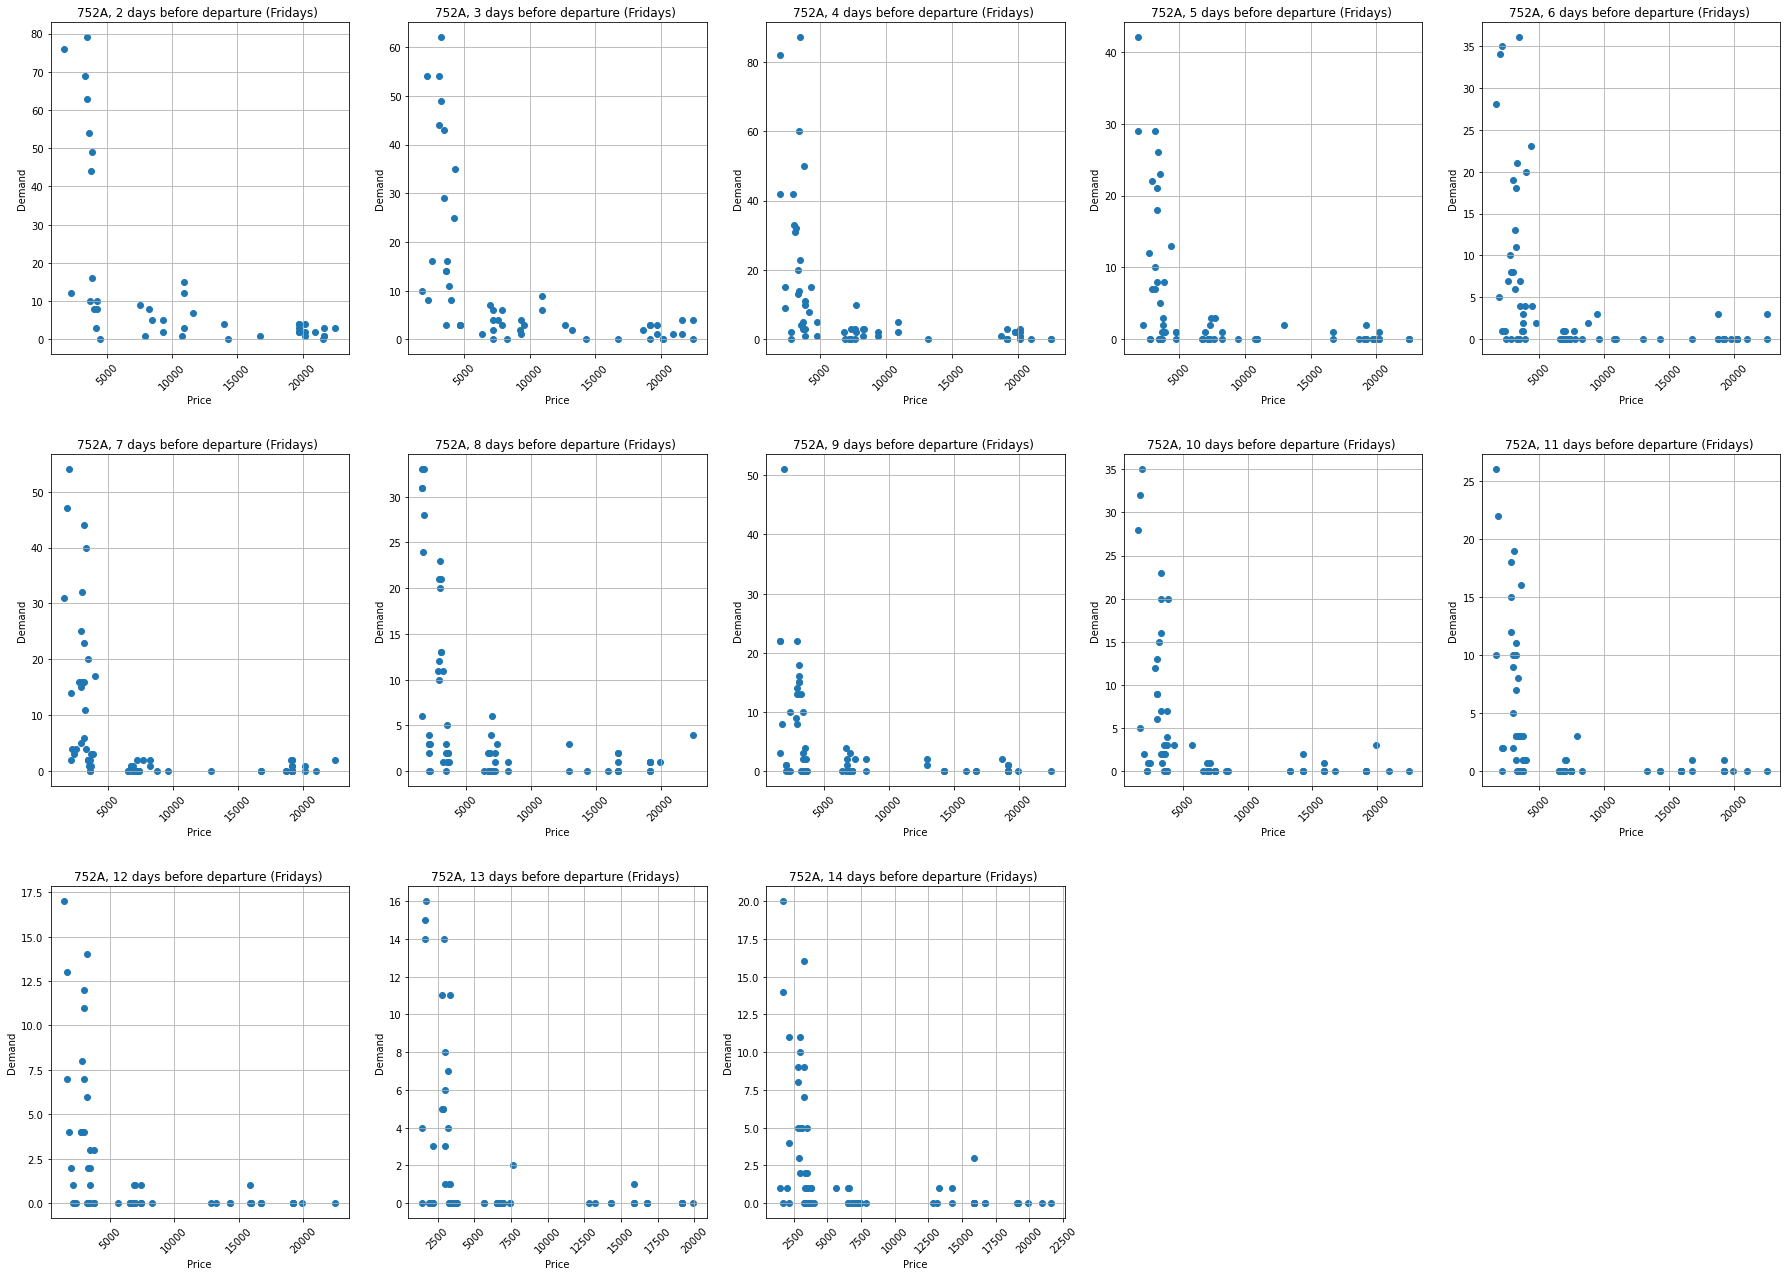

In [8]:
%%time
days=np.arange(2, 15)
folder='Experiments/Surrogate modeling/Figure/'
plots.scatter_plot(prices.loc[train_name].loc[wk_day], demand.loc[train_name].loc[wk_day], days, train_name+' '+wk_day, 'original PED', save=True, folder=folder)

In [28]:
prices.to_csv('Experiments\Surrogate modeling\Data\prices.csv')
demand.to_csv('Experiments\Surrogate modeling\Data\demand.csv')
places.to_csv('Experiments\Surrogate modeling\Data\places.csv')
prices_cons.to_csv('Experiments\Surrogate modeling\Data\prices_cons.csv')

## Removing duplicates and averaging

In [9]:
%%time
mean_prices=pd.DataFrame(data=np.nan, columns=prices.columns, index=prices.index, dtype="float")
mean_demand=pd.DataFrame(data=np.nan, columns=demand.columns, index=demand.index, dtype="float")
for num in uniq_train_num:
    for wk_day in wk_days_mask:
        for day in demand.columns:
            pr_dem_piv=processing.mean_duplicate_prices(prices.loc[num].loc[wk_day][day], 
                                             demand.loc[num].loc[wk_day][day])
            
            flat_pr_dem_piv=processing.flat_grouped_classes(pr_dem_piv)
            
            mean_prices.loc[num, wk_day].T.loc[day]=flat_pr_dem_piv.set_index(['date', 'class'])['prices']
            mean_demand.loc[num, wk_day].T.loc[day]=flat_pr_dem_piv.set_index(['date', 'class'])['demand']

Wall time: 21min 35s


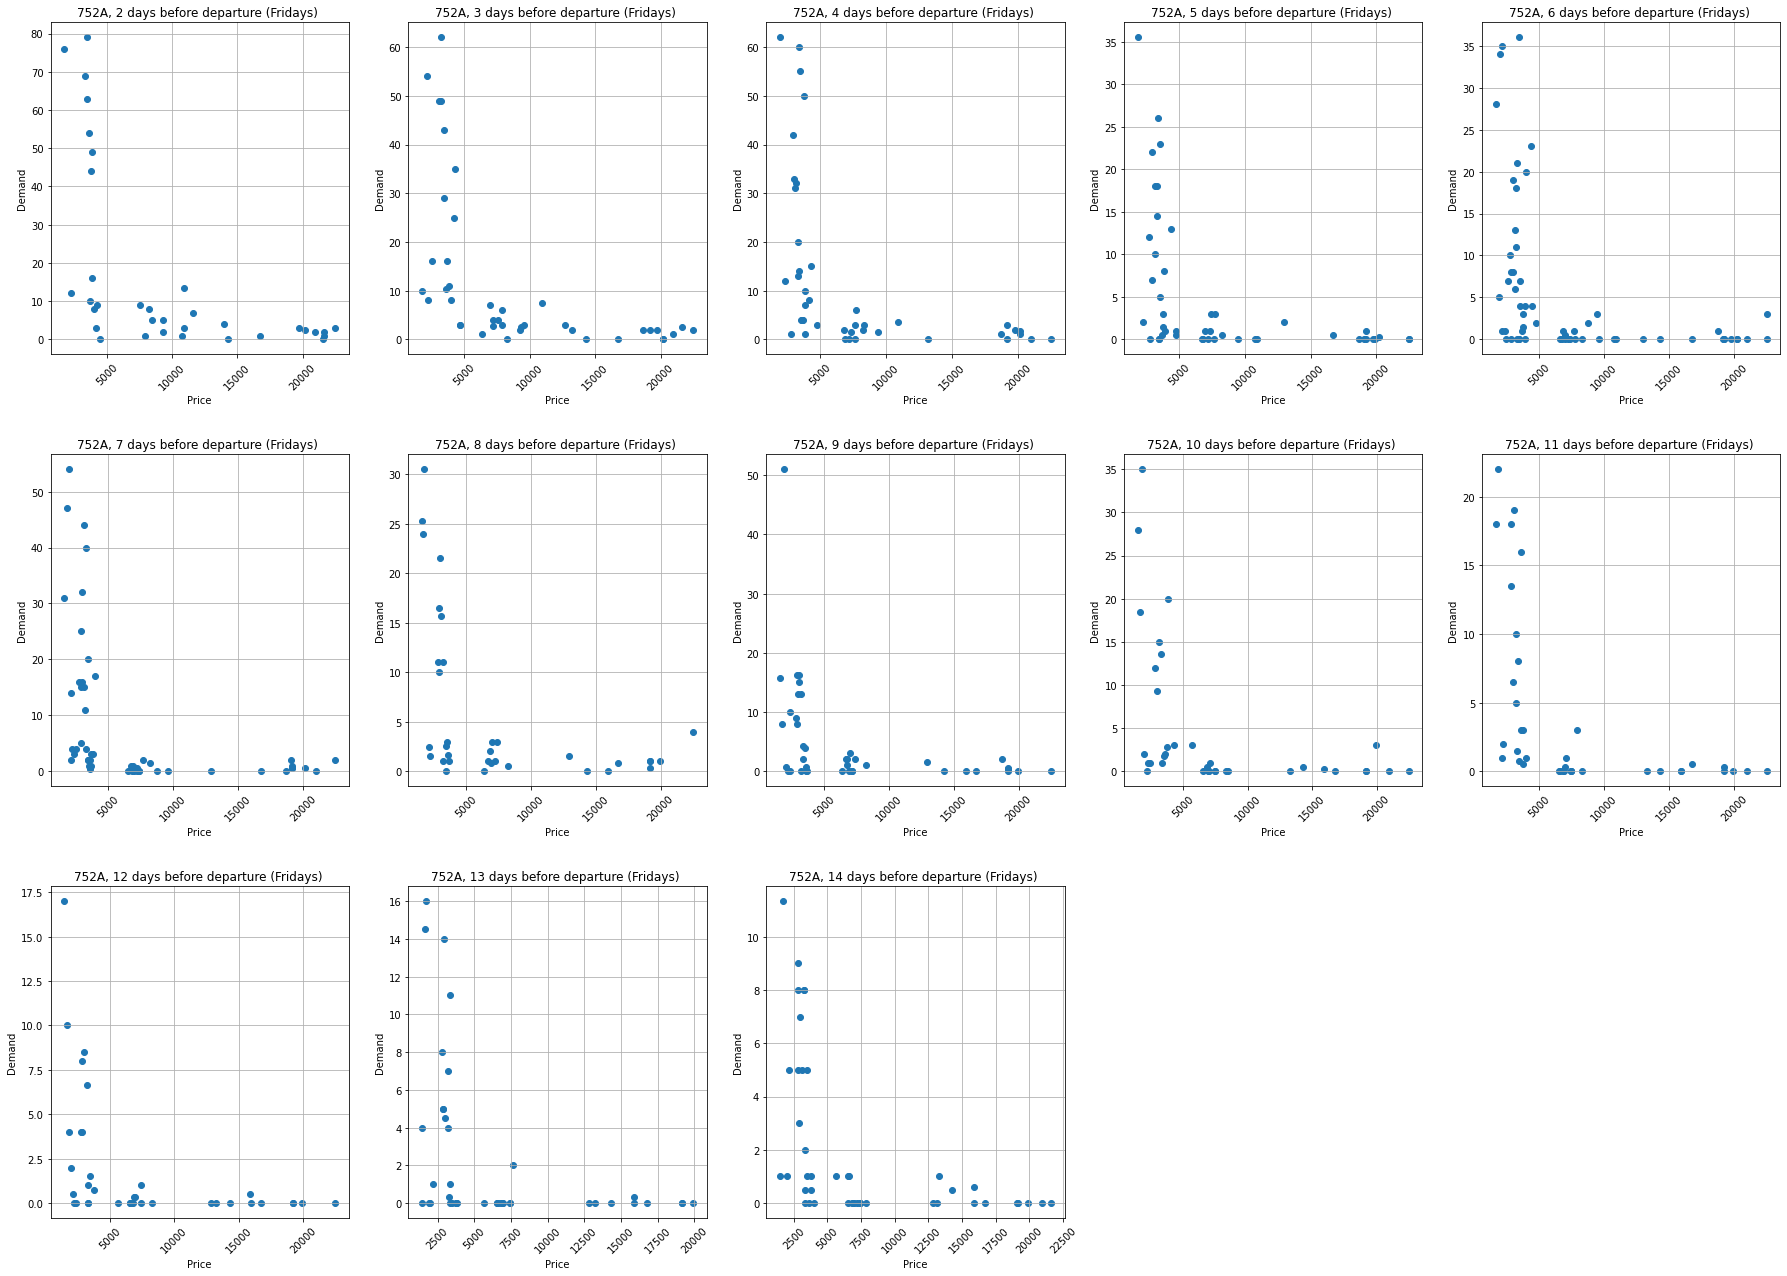

In [10]:
days=np.arange(2, 15)
train_name='752А'
wk_day='Friday'
folder='Experiments/Surrogate modeling/Figure/'
plots.scatter_plot(mean_prices.loc[train_name].loc[wk_day], mean_demand.loc[train_name].loc[wk_day], days, train_name+' '+wk_day, 'processed PED', save=True, folder=folder)

In [11]:
mean_prices.to_csv('Experiments\Surrogate modeling\Data\mean_prices.csv')
mean_demand.to_csv('Experiments\Surrogate modeling\Data\mean_demand.csv')